# Clustering the Alanine Dipeptide using Metadynamics Weights

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
from shapeGMMTorch import torch_sgmm
import torch

## Read trajectory

Read the trajectory.  This trajectory contains 100k frames of alanine dipeptide (ADP) run with standard metadynamics.  Details of the simulation can be found in the input file but what is most important here is that this is a biased MD simulation.  Thus each frame does contribute equally to the unbiased distribution.  

In [2]:
prmtopFileName = "run_ala2_metad_sigma0.3_height1.2_pace500.gro"
trajFileName = "run_ala2_metad_sigma0.3_height1.2_pace500.xtc"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('name C N CA')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
traj_data = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    traj_data[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 22
Number of frames in trajectory: 100001
Number of atoms in selection: 5


## Perform Cross Validation with Uniform Weights

We will start by assuming each frame has equal weight.  This is wrong but will serve as a reference.  We will use the the cross validation script contained in the shapeGMM scripts file.

In [5]:
# scripts contains a built-in CV routine
from shapeGMMTorch import scripts

We will scan from 1 to 6 clusters.

In [6]:
# define cluster array
cluster_array = np.arange(1,7,1).astype(int)

In [ ]:
# uniform weights
train, cv = scripts.cross_validate_cluster_scan(traj_data, 10000, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 10, dtype=torch.float32, device=torch.device("cpu"))

Number of frames to train each model: 10000
Number of frames to predict each model: 90001
Number of training sets: 3
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              19.693          29.432
              1               2               1              20.730          62.169
              1               2               2              20.735          84.353
              1               2               3              20.731          68.888
              1               2               4              20.730          71.162
              1               2               5              20.735          63.000
              1               2               6              20.731          71.293
              1               2               7              20.5

## Perform Cross Validation with MetaD Weights for each Frame

We will read the metadynamics weight from the colvar file.  ***Note that there are various ways of determining a weight per frame from metadynamics simulations.  Here we will choose the exponential of $V(s,t)-c(t)$.***

In [ ]:
# load the weights from c(t)/rbias column in the metaD colvars file
frame_weights = np.loadtxt("run_ala2_metad_sigma0.3_height1.2_pace500.colvars.dat",comments="#")[:,-2]
# exponential
frame_weights = np.exp(frame_weights/0.593)
# normalize
frame_weights /= np.sum(frame_weights)
print(np.sum(frame_weights))

In [ ]:
# CV scan with non-uniform weights
metaD_train, metaD_cv = scripts.cross_validate_cluster_scan(traj_data, 10000, frame_weights = frame_weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 10, dtype=torch.float32, device=torch.device("cpu"))

### Save and load log likelihood data for quick use

In [ ]:
# save data (optional - don't have to do this)
np.savetxt("uniform_frame_weights_ll_train_5atoms.dat", train)
np.savetxt("uniform_frame_weights_ll_cv_5atoms.dat", cv)
np.savetxt("metaD_frame_weights_ll_train_5atoms.dat", metaD_train)
np.savetxt("metaD_frame_weights_ll_cv_5atoms.dat", metaD_cv)

In [8]:
# load data
# NOTE - only do this if you want to overwrite active arrays
train = np.loadtxt("uniform_frame_weights_ll_train_5atoms.dat")
cv = np.loadtxt("uniform_frame_weights_ll_cv_5atoms.dat")
metaD_train = np.loadtxt("metaD_frame_weights_ll_train_5atoms.dat")
metaD_cv = np.loadtxt("metaD_frame_weights_ll_cv_5atoms.dat")

## Make Log Likelihood vs number of Cluster Plots

In [ ]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
from shapeGMMTorch import plots
# also need to load matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# create figure
fig, ax = plt.subplots(1,2,figsize=(8,4), dpi= 120, facecolor='w', edgecolor='k',sharex=True,sharey=True)
# Uniform Weights
ax[0].set_title("Uniform",fontsize=12)
plots.plot_log_likelihood_with_dd(ax[0],cluster_array,train,cv,fontsize=12,ylabel1=True,ylabel2=False,xlabel=True)
# metaD Weights
ax[1].set_title("metaD",fontsize=12)
plots.plot_log_likelihood_with_dd(ax[1],cluster_array,metaD_train,metaD_cv,fontsize=12,ylabel1=False,ylabel2=False,xlabel=True)
plt.tight_layout()
plt.show()

## Fit a $n_{clusters}=4$ object with metaD weights

In [53]:
# fit a shapeGMM object for n=4 with metaD weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_metaD_weights_4clusters = scripts.sgmm_fit_with_attempts(traj_data, 4, 30, frame_weights,device=torch.device("cpu"))

Number of training frames: 100001
Number of clusters: 4
Number of attempts: 30
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              27.314         528.938
       2              27.372         488.022
       3              27.373         539.325
       4              27.321         523.930
       5              27.286         521.829
       6              27.331         522.407
       7              27.443        1094.666
       8              27.278         355.194
       9              27.238         360.285
      10              27.328         534.132
      11              27.343         733.430
      12              27.329         535.079
      13              27.311         322.326
      14              27.285         512.454
      15              27.366         536.917
      16              27.268         357.257
      17              27.373         546.634
      18              27.373         778.252
      19       

In [49]:
# save object
import pickle
fileObj = open('sgmm_4clusters_metaD_weights_5atoms.obj', 'wb')
pickle.dump(sgmm_metaD_weights_4clusters,fileObj)
fileObj.close()

## Fit a $n_{clusters}=3$ object with metaD weights

In [60]:
# fit a shapeGMM object for n=3 with metaD weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_metaD_weights = scripts.sgmm_fit_with_attempts(traj_data, 3, 30, frame_weights,device=torch.device("cpu"))

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 30
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              26.762        1251.027
       2              26.524         709.476
       3              26.523         681.030
       4              26.468         292.504
       5              26.367         495.996
       6              25.963         616.748
       7              26.828        1138.088
       8              25.974         293.483
       9              26.452         389.842
      10              26.456         336.984
      11              26.754        1263.214
      12              26.523         708.373
      13              26.762        1166.920
      14              26.455         565.392
      15              26.828        1140.579
      16              26.353         373.287
      17              26.523         625.126
      18              26.747         416.350
      19       

In [62]:
# save object
import pickle
fileObj = open('sgmm_3clusters_metaD_weights_5atoms.obj', 'wb')
pickle.dump(sgmm_metaD_weights,fileObj)
fileObj.close()

## Fit a $n_{clusters}=2$ object with metaD weights

In [61]:
# fit a shapeGMM object for n=2 with metaD weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_metaD_weights_2clusters = scripts.sgmm_fit_with_attempts(traj_data, 2, 30, frame_weights,device=torch.device("cpu"))

Number of training frames: 100001
Number of clusters: 2
Number of attempts: 30
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              25.202         621.364
       2              25.239         451.423
       3              25.202         606.374
       4              22.959         876.393
       5              25.401         817.138
       6              25.239         469.577
       7              25.202         628.905
       8              25.238         485.056
       9              25.238         493.646
      10              25.239         486.238
      11              25.202         647.841
      12              25.202         625.863
      13              25.203         629.245
      14              25.145         347.689
      15              25.097         468.163
      16              25.202         637.950
      17              25.238         468.822
      18              25.097         690.263
      19       

In [63]:
# save object
import pickle
fileObj = open('sgmm_2clusters_metaD_weights_5atoms.obj', 'wb')
pickle.dump(sgmm_metaD_weights_2clusters,fileObj)
fileObj.close()

## Uniform Weights

In [65]:
# fit a shapeGMM object for n=4 with uniform weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_uniform_weights = scripts.sgmm_fit_with_attempts(traj_data, 3, 30, np.ones(frame_weights.shape),device=torch.device("cpu"))

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 30
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              21.547        1376.546
       2              21.045         732.411
       3              21.556        1595.707
       4              21.137         952.789
       5              21.547        1395.767
       6              21.074         839.038
       7              21.547        1583.228
       8              21.551        1312.588
       9              21.230         886.021
      10              21.230         937.797
      11              21.227        1175.582
      12              21.547        1422.289
      13              21.547        1019.711
      14              21.547        1435.538
      15              21.548         942.510
      16              21.194         725.901
      17              21.232        1320.416
      18              21.222        1070.084
      19       

In [66]:
# save object
import pickle
fileObj = open('sgmm_3clusters_uniform_weights_5atoms.obj', 'wb')
pickle.dump(sgmm_uniform_weights,fileObj)
fileObj.close()

## Ramachandran Plots

In [14]:
# compute phi psi
from MDAnalysis.analysis import dihedrals
protein = coord.select_atoms("protein")
rama = dihedrals.Ramachandran(protein).run()
print(rama.results.angles.shape)

(100001, 1, 2)


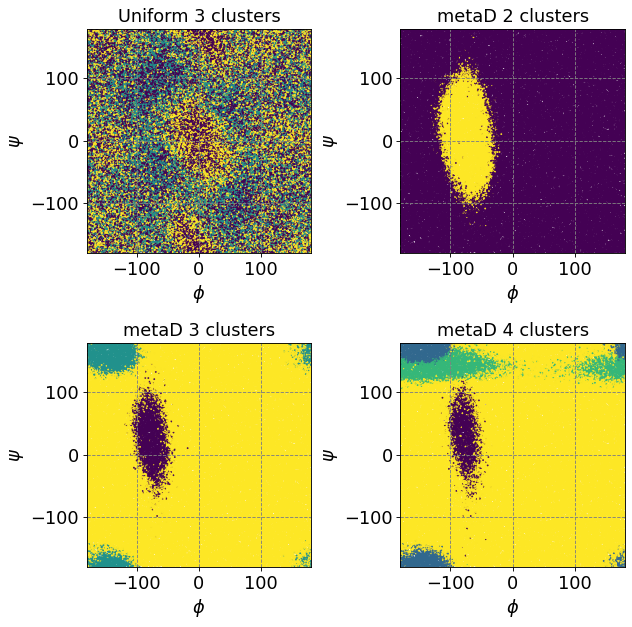

In [67]:
# Make Ramachandran plot
def rama_plot(ax,phi,psi,c,title,fontsize=16):
    # make a grid
    ax.grid(which='major', axis='both', color='#808080', linestyle='--')
    # set ticks and axis labels
    ax.tick_params(axis='both',labelsize=fontsize)
    ax.set_ylabel("$\psi$",fontsize=fontsize)
    ax.set_xlabel("$\phi$",fontsize=fontsize)
    ax.set_title(title,fontsize=fontsize)
    # scatter plot
    ax.scatter(phi, psi,c=c,s=0.4)
    # enforce range
    ax.set_ylim(-180,180)
    ax.set_xlim(-180,180)
    # equal aspect ratio
    ax.set_aspect("equal")



fontsize=16
phi = rama.results.angles[:,0,0]
psi = rama.results.angles[:,0,1]
fig, ax = plt.subplots(2,2,figsize=(8,8),dpi=80)
c = sgmm_uniform_weights.cluster_ids
rama_plot(ax[0,0],phi,psi,c,"Uniform 3 clusters")
c = sgmm_metaD_weights_2clusters.cluster_ids
rama_plot(ax[0,1],phi,psi,c,"metaD 2 clusters")
c = sgmm_metaD_weights.cluster_ids
rama_plot(ax[1,0],phi,psi,c,"metaD 3 clusters")
c = sgmm_metaD_weights_4clusters.cluster_ids
rama_plot(ax[1,1],phi,psi,c,"metaD 4 clusters")

#show plot
plt.tight_layout()
plt.show()

In [70]:
ll_per_frame = sgmm_metaD_weights.train_frame_log_likelihood/sgmm_metaD_weights.frame_weights
ll_per_frame_2clusters = sgmm_metaD_weights_2clusters.train_frame_log_likelihood/sgmm_metaD_weights_2clusters.frame_weights
ll_per_frame_4clusters = sgmm_metaD_weights_4clusters.train_frame_log_likelihood/sgmm_metaD_weights_4clusters.frame_weights

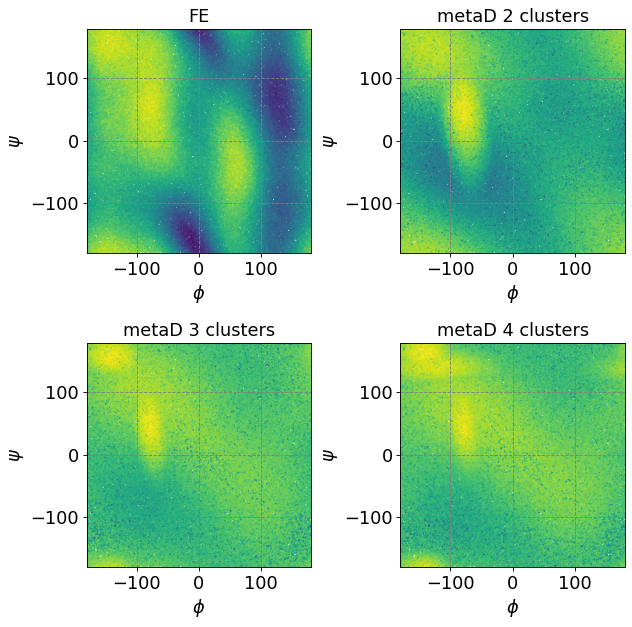

In [72]:
fontsize=16
phi = rama.results.angles[::1,0,0]
psi = rama.results.angles[::1,0,1]
fig, ax = plt.subplots(2,2,figsize=(8,8),dpi=80)
c = np.log(frame_weights)
rama_plot(ax[0,0],phi,psi,c,"FE")
c = ll_per_frame_2clusters-np.amin(ll_per_frame_2clusters)
c /= np.sum(c)
rama_plot(ax[0,1],phi,psi,c,"metaD 2 clusters")
c = ll_per_frame-np.amin(ll_per_frame)
c /= np.sum(c)
rama_plot(ax[1,0],phi,psi,c,"metaD 3 clusters")
c = ll_per_frame_4clusters-np.amin(ll_per_frame_4clusters)
c /= np.sum(c)
phi = rama.results.angles[::1,0,0]
psi = rama.results.angles[::1,0,1]
rama_plot(ax[1,1],phi,psi,c,"metaD 4 clusters")

#show plot
plt.tight_layout()
plt.show()